In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_TFiso1_collection,
                          load_full_y2h_data_including_controls,
                          load_valid_isoform_clones,
                          load_ref_vs_alt_isoforms_table)

In [2]:
m1h = load_m1h_activation_data()
tfs = load_annotated_TFiso1_collection()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

df = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
df = df[df["clone_acc_alt"] != "RORC|1/6|05F11"]

df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene_symbol')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

# add activation or repression
effector_domain_type = {}
for tf in tfs.values():
    for d in tf.cloned_reference_isoform.aa_seq_features:
        if d.category == 'effector_domain':
            effector_domain_type[d.accession] = d.name
dom['type'] = dom['accession'].map(effector_domain_type)


# considering EFFECTOR DOMAINS ONLY
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    df['length_of_{}_domains'.format(effector_type)] = df.apply(domain_length, effector_type=effector_type, axis=1)

reading from cache


In [3]:
# now add Pfam AD/RDs
pfam = pd.read_csv('../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])
# AD
pfam_ad = pfam[(pfam['name'].str.contains("transcription activation")) | 
               (pfam['name'].str.contains("transactivation")) |
               (pfam['short_name'].str.contains("TAD"))].copy()
pfam_ad["type"] = "AD"

# RD
pfam_rd = pfam[(pfam['short_name'].str.contains("NRIP1_repr")) | 
               (pfam['name'].str.contains("KRAB"))].copy()
pfam_rd["type"] = "RD"
pfam_effs = pd.concat([pfam_ad, pfam_rd])

# get pfam type
def get_pfam_type(row):
    if not pd.isnull(row['type']):
        return row['type']
    else:
        pfam_sub = pfam_effs[pfam_effs['pfam_accession'] == row['accession']]
        if len(pfam_sub) > 0:
            return pfam_sub['type'].iloc[0]
        else:
            return np.nan
dom["type_incl_pfam"] = dom.apply(get_pfam_type, axis=1)

# considering Pfam and Effector domains
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type_incl_pfam'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed_incl_pfam'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains_incl_pfam'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    df['length_of_{}_domains_incl_pfam'.format(effector_type)] = df.apply(domain_length, effector_type=effector_type, axis=1)

Text(0.5, 0, 'Effector domains in reference isoform')

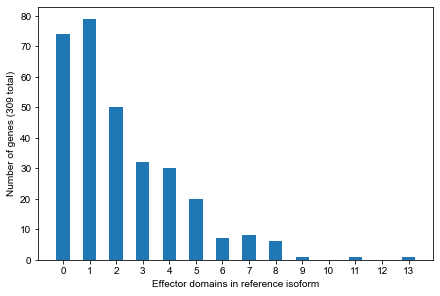

In [4]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain':
            c += 1
    return c

n_effector = [count_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')

Text(0.5, 1.0, 'Soto et al. data')

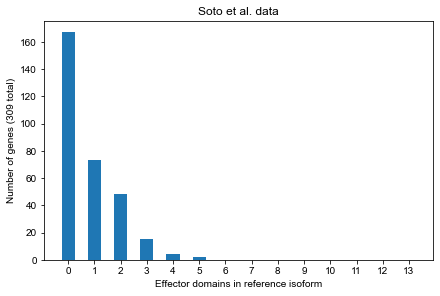

In [5]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Soto_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_soto = [count_Soto_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector_soto,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Soto et al. data')

Text(0.5, 1.0, 'Data from Bintu lab papers')

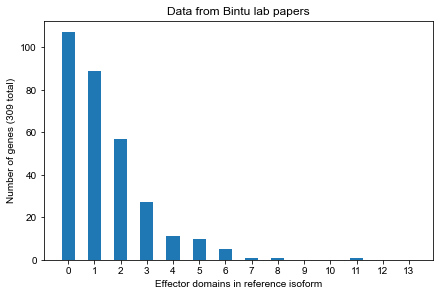

In [6]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Bintu_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and not d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_bintu = [count_Bintu_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1)
ax.hist(n_effector_bintu,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Data from Bintu lab papers')

In [7]:
# Summary stats
counter = {'Soto': 0,
           'Tycko': 0,
           'DelRosso': 0}
genes_with_effector = 0
genes_with_soto_effector = 0
for tf in tfs.values():
    has_effector = False
    has_soto_effector = False
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category == 'effector_domain':
            has_effector = True
            if domain.accession.startswith('Soto'):
                has_soto_effector = True
            counter[domain.accession.split('_')[0]] += 1
    if has_effector:
        genes_with_effector += 1
    if has_soto_effector:
        genes_with_soto_effector += 1
print(counter)
print(genes_with_effector, genes_with_soto_effector, len(tfs))

{'Soto': 240, 'Tycko': 52, 'DelRosso': 382}
235 142 309


In [8]:
counter = {'Soto': {'AD': 0, 'RD': 0, 'Bif': 0},
           'Tycko': {'AD': 0, 'RD': 0},
           'DelRosso': {'AD': 0, 'RD': 0}}
for tf in tfs.values():
    has_effector = False
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category == 'effector_domain':
            counter[domain.accession.split('_')[0]][domain.name] += 1
counter

{'Soto': {'AD': 156, 'RD': 80, 'Bif': 4},
 'Tycko': {'AD': 4, 'RD': 48},
 'DelRosso': {'AD': 37, 'RD': 345}}

Text(0, 0.5, 'Number of effector domains')

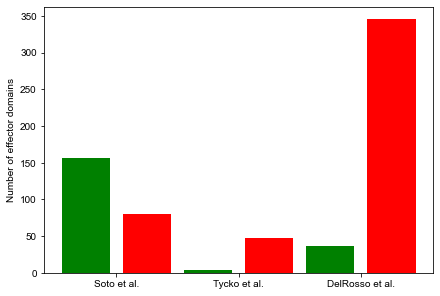

In [9]:
fig, ax = plt.subplots(1, 1)
ax.bar(x=range(6),
       height=[counter[x][y] for x in counter.keys() for y in ['AD', 'RD']],
       color=['green', 'red'] * 3)
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Soto et al.', 'Tycko et al.', 'DelRosso et al.'])
ax.set_ylabel('Number of effector domains')

Text(0.5, 1.0, 'Tycko et al. + DelRosso et al.')

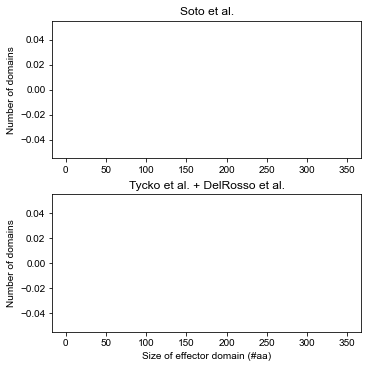

In [10]:
# length distribution of Soto vs Bintu lab domains
len_soto = []
len_bintu = []
for tf in tfs.values():
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category != 'effector_domain':
            continue
        if domain.accession.startswith('Soto'):
            len_soto.append(len(dom))
        else:
            len_bintu.append(len(dom))

fig, axs = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(h=5, w=5)
axs[0].hist(len_soto, range=(1, 350), bins=35)
axs[1].hist(len_bintu, range=(1, 350), bins=35)
axs[1].set_xlabel('Size of effector domain (#aa)')
for ax in axs:
    ax.set_ylabel('Number of domains')
axs[0].set_title('Soto et al.')
axs[1].set_title('Tycko et al. + DelRosso et al.')

In [11]:
# compare activation and repression

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


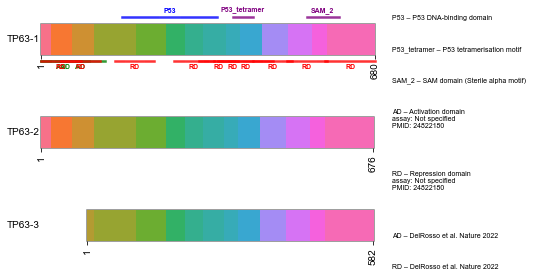

In [12]:
# look at tf with 13
list(tfs.values())[n_effector.index(13)].protein_diagram()

In [13]:
tfs['TP63']['TP63-1'].aa_seq_features[5].accession

'Soto_Effector 0778'

In [14]:
print('Effector domain types:')
dom['type'].value_counts()

Effector domain types:


RD     1796
AD      749
Bif      10
Name: type, dtype: int64

In [15]:
print('Effector domain types including Pfam:')
dom['type_incl_pfam'].value_counts()

Effector domain types including Pfam:


RD     1965
AD      789
Bif      10
Name: type_incl_pfam, dtype: int64

In [16]:
print('Number of different types of effector domains per gene')
dom.groupby('gene_symbol')['type'].nunique().value_counts().sort_index()

Number of different types of effector domains per gene


0     63
1    144
2     81
3      2
Name: type, dtype: int64

In [17]:
print('Number of different types of effector domains per gene including Pfam')
dom.groupby('gene_symbol')['type_incl_pfam'].nunique().value_counts()

Number of different types of effector domains per gene including Pfam


1    169
2     84
0     35
3      2
Name: type_incl_pfam, dtype: int64

In [18]:
(df.loc[df['activation_fold_change_log2'].notnull(),
        ['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed']]
    .notnull()
    .groupby(['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed'])
    .size())

fraction_of_AD_domains_removed  fraction_of_RD_domains_removed  fraction_of_Bif_domains_removed
False                           False                           False                               69
                                                                True                                 1
                                True                            False                              137
                                                                True                                 1
True                            False                           False                               26
                                True                            False                               89
                                                                True                                 4
dtype: int64

In [19]:
# color map
t_disorder = df.loc[:,'f_disorder_difference'].values
norm = plt.Normalize(np.nanmin(t_disorder), np.nanmax(t_disorder))
cmap = sns.color_palette("flare", as_cmap=True)
palette_disorder = {value: cmap(norm(value)) for value in t_disorder}

def re_color(row, palette):
    if pd.isnull(row['f_disorder_difference']):
        color = palette[0]
    else:
        color = palette[row['f_disorder_difference']]
    return color

df["color_disorder"] = df.apply(re_color, axis=1, palette=palette_disorder)

# set na f_disorder_difference to 0 for now
df["f_disorder_difference"].fillna(0, inplace=True)

In [20]:
# color map - length instead
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
df['tot_dom_length'] = df[['length_of_AD_domains', 'length_of_RD_domains', 'length_of_Bif_domains']].sum(axis=1)
t_dom_length = df.loc[:,'tot_dom_length'].values
t_dom_length = t_dom_length[t_dom_length > 0]

# using min and max makes colors too hard too read - cut off
norm = plt.Normalize(25, 250)
palette_dom_length = {value: cmap(norm(value)) for value in t_dom_length}

def re_color2(row, palette):
    if row['tot_dom_length'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length']]
    return color

df["color_dom_length"] = df.apply(re_color2, axis=1, palette=palette_dom_length)

In [21]:
# color map - length instead
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
df['tot_dom_length_incl_pfam'] = df[['length_of_AD_domains_incl_pfam', 'length_of_RD_domains_incl_pfam', 'length_of_Bif_domains_incl_pfam']].sum(axis=1)
t_dom_length_incl_pfam = df.loc[:,'tot_dom_length_incl_pfam'].values
t_dom_length_incl_pfam = t_dom_length_incl_pfam[t_dom_length_incl_pfam > 0]

# using min and max makes colors too hard too read - cut off
norm = plt.Normalize(25, 250)
palette_dom_length_incl_pfam = {value: cmap(norm(value)) for value in t_dom_length_incl_pfam}

def re_color3(row, palette):
    if row['tot_dom_length_incl_pfam'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length_incl_pfam']]
    return color

df["color_dom_length_incl_pfam"] = df.apply(re_color3, axis=1, palette=palette_dom_length_incl_pfam)
df.sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,length_of_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,length_of_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains,length_of_Bif_domains,fraction_of_AD_domains_removed_incl_pfam,insertion_in_AD_domains_incl_pfam,length_of_AD_domains_incl_pfam,fraction_of_RD_domains_removed_incl_pfam,insertion_in_RD_domains_incl_pfam,length_of_RD_domains_incl_pfam,fraction_of_Bif_domains_removed_incl_pfam,insertion_in_Bif_domains_incl_pfam,length_of_Bif_domains_incl_pfam,color_disorder,tot_dom_length,color_dom_length,tot_dom_length_incl_pfam,color_dom_length_incl_pfam
46,E2F6,ENSG00000169016,E2F,True,E2F6|1/2|10C02,E2F6|2/2|01A04,ENST00000381525,ENST00000542100|ENST00000546212,False,False,True,281,206,7,5,True,False,False,False,True,False,False,False,0.0,18.461538,True,73.3,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.873302,4.948795,3.075493,E2F6-1,E2F6-2,0.893333,partially disordered,True,3.075493,NaN,NaN,NaN,0.00000,0.0,219.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,219.0,NaN,NaN,NaN,"(0.39030735, 0.16278924, 0.41625344, 1.0)",219.0,"(0.41984535, 0.16863258, 0.42484219, 1.0)",219.0,"(0.41984535, 0.16863258, 0.42484219, 1.0)"
270,IRF9,ENSG00000213928,IRF,True,IRF9|1/6|04C06,IRF9|5/6|04H03,ENST00000396864,NaN,False,True,True,393,236,8,7,True,True,False,True,True,False,False,False,0.0,87.619048,True,34.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,NaN,0.201537,NaN,IRF9-1,IRF9-5,0.066890,partially disordered,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.92354597, 0.62457749, 0.46433898, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",0.0,"(0.9155979, 0.55210684, 0.42070204)"
331,STAT5A,ENSG00000126561,STAT,True,STAT5A|1/2|10E11,STAT5A|2/2|06A01,ENST00000345506|ENST00000590949,ENST00000587646,False,False,True,794,229,18,6,True,True,False,True,True,False,False,False,0.0,100.000000,True,28.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.680086,2.861579,-0.818507,STAT5A-1,STAT5A-2,0.097002,partially disordered,True,0.818507,0.757062,1.0,177.0,1.00000,0.0,180.0,NaN,NaN,NaN,0.757062,1.0,177.0,1.00000,0.0,180.0,NaN,NaN,NaN,"(0.92077582, 0.59804722, 0.44818634, 1.0)",357.0,"(0.29408557, 0.13721193, 0.38442775, 1.0)",357.0,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
258,FOXN4,ENSG00000139445,Forkhead,False,FOXN4|1/2|10F06,FOXN4|2/2|10A07,ENST00000299162,ENST00000355216,False,False,True,517,337,9,4,True,False,False,False,True,False,False,False,18.0,7.954545,True,63.6,6.0,1.0,6.0,6.0,1.0,1.0,5.0,-5.0,0.166667,NaN,loses some,loses all,loses some,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,6.800525,7.028204,0.227679,FOXN4-1,FOXN4-2,0.

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-22-9a847076ccfb>:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-22-9a847076ccfb>:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-22-9a847076ccfb>:165: FutureWarning: In a future version, object-dtype columns with all-bool values will not 

found: 0.4, -1.0995217184549233
found: 0.0, -4.185867921507783
found: 0.20211733291275724, -1.3738165060156255


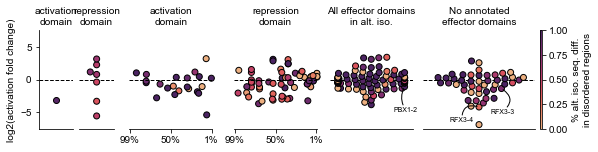

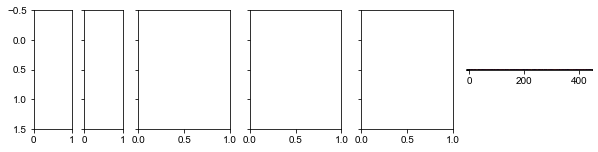

In [22]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_disorder
hue = 'f_disorder_difference'
color = 'color_disorder'
t = t_disorder

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()

# annotate RFX3-3
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-3", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.7"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-4", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.7"), 
                            ha="right", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[5], aspect=60, label="% alt. iso. seq. diff.\nin disordered regions")


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_colored_by_disorder.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-23-4046ef48344d>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-23-4046ef48344d>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-23-4046ef48344d>:179: FutureWarning: In a future version, object-dtype columns with all-bool values will not 

found: -8.881784197001252e-16, -4.185867921507783
found: 0.37028447362844474, -1.3738165060156264
found: -0.4, -1.0995217184549233


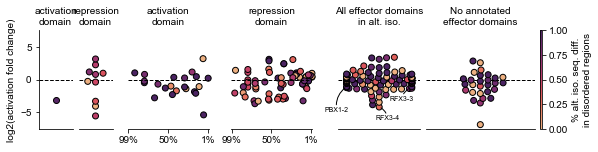

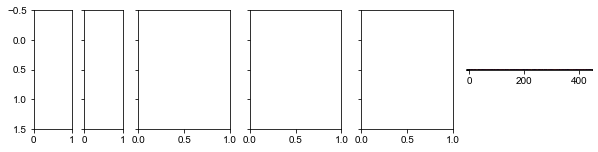

In [23]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_disorder
hue = 'f_disorder_difference'
color = 'color_disorder'
t = t_disorder

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                        & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[5], aspect=60, label="% alt. iso. seq. diff.\nin disordered regions")


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_disorder.pdf', bbox_inches='tight')

In [24]:
tot_loss_repr[["gene_symbol", "clone_acc_ref", "clone_acc_alt", "f_disorder_difference", "color_disorder", 
               "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,f_disorder_difference,color_disorder,activation_fold_change_log2
40,DLX1,DLX1|1/2|07A12,DLX1|2/2|07E09,0.653333,"(0.61501835, 0.21316435, 0.43793808, 1.0)",3.122124
101,ZNF131,ZNF131|2/5|02A07,ZNF131|5/5|02E05,0.518198,"(0.74426345, 0.24850191, 0.41136599, 1.0)",-5.544909
113,ZSCAN26,ZSCAN26|1/2|02H03,ZSCAN26|2/2|02D03,0.455224,"(0.79876118, 0.27347974, 0.39064559, 1.0)",-0.390594
153,FOXP2,FOXP2|2/10|07B01,FOXP2|10/10|06A10,0.544776,"(0.71837612, 0.24102046, 0.41863486, 1.0)",2.235620
160,HOXA1,HOXA1|1/2|04F04,HOXA1|2/2|04F05,0.760369,"(0.51648277, 0.18774266, 0.44139128, 1.0)",1.149260
167,DLX5,DLX5|1/2|06G01,DLX5|2/2|06H01,0.631579,"(0.63695183, 0.21916625, 0.43502123, 1.0)",0.773005
193,CREM,CREM|1/3|09D12,CREM|3/3|10D01,0.375635,"(0.8513284, 0.32604977, 0.36620106, 1.0)",-3.308728
305,ZNF263,ZNF263|1/3|11C01,ZNF263|3/3|05A08,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)",-4.057763
312,ZFP1,ZFP1|2/4|04D02,ZFP1|4/4|04C01,0.379947,"(0.84916723, 0.32289973, 0.36711424, 1.0)",0.957208
315,ZSCAN32,ZSCAN32|1/5|05B06,ZSCAN32|2/5|05F05,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)",-0.282397


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-25-1e778ad2a813>:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-25-1e778ad2a813>:165: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
<ipython-input-25-1e778ad2a813>:165: FutureWarning: In a future version, object-dtype columns with all-bool values will not 

found: 0.4, -1.0995217184549233
found: 0.0, -4.185867921507783
found: 0.20211733291275724, -1.3738165060156255


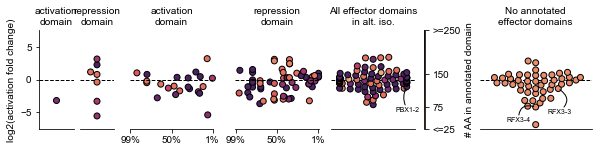

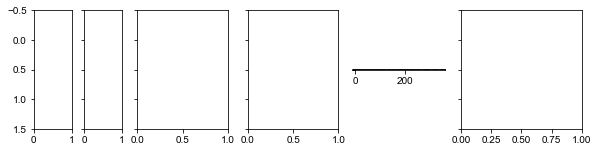

In [25]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length
hue = 'tot_dom_length'
color = 'color_dom_length'
t = t_dom_length

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')

# annotate RFX3-3
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-3", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.7"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-4", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.7"), 
                            ha="right", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
            
# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_colored_by_dom_length.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -8.881784197001252e-16, -4.185867921507783
found: 0.37028447362844474, -1.3738165060156264
found: -0.4, -1.0995217184549233


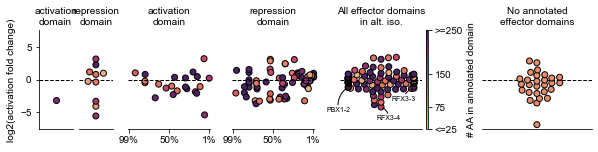

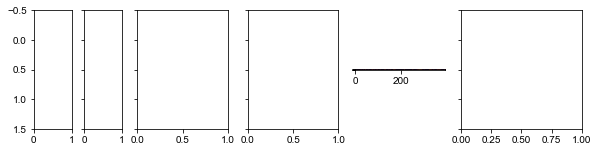

In [26]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length_incl_pfam
hue = 'tot_dom_length_incl_pfam'
color = 'color_dom_length_incl_pfam'
t = t_dom_length_incl_pfam

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                        & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_dom_length.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 44.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -8.881784197001252e-16, -4.185867921507784
found: -0.3368415198244641, -1.3738165060156273
found: -0.4, -1.099521718454925


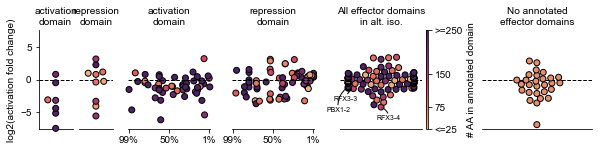

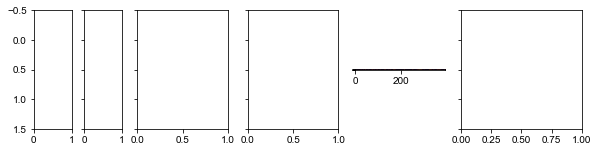

In [27]:
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
palette = palette_dom_length_incl_pfam
hue = 'tot_dom_length_incl_pfam'
color = 'color_dom_length_incl_pfam'
t = t_dom_length_incl_pfam

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed_incl_pfam',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
                & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
                        ), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
                  &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
                             (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
                          (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
                          & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(-10, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[5].set_xticks([])
axs[5].set_xlabel('')


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[4].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[4], aspect=60, label="# AA in annotated domain")
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal_incl_pfam_colored_by_dom_length_lossen-requirements.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


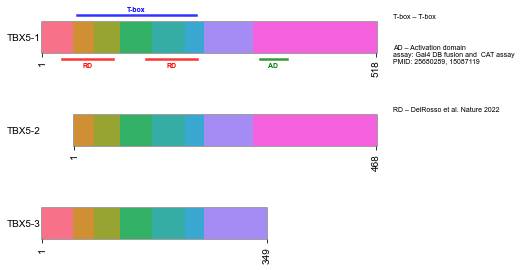

In [28]:
tfs['TBX5'].protein_diagram()

In [29]:
df[df["gene_symbol"] == "PBX1"][["gene_symbol", "clone_acc_ref", "clone_acc_alt", "fraction_of_AD_domains_removed",
                                 "fraction_of_RD_domains_removed", "fraction_of_Bif_domains_removed",
                                 "m1h_gte_2_fold_at_least_one_iso_per_gene",
                                 "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,fraction_of_AD_domains_removed,fraction_of_RD_domains_removed,fraction_of_Bif_domains_removed,m1h_gte_2_fold_at_least_one_iso_per_gene,activation_fold_change_log2
20,PBX1,PBX1|1/2|02A05,PBX1|2/2|02C05,NaN,0.0,NaN,True,-1.099522


<AxesSubplot: xlabel='f_disorder_difference', ylabel='abs_activation_fold_change_log2'>

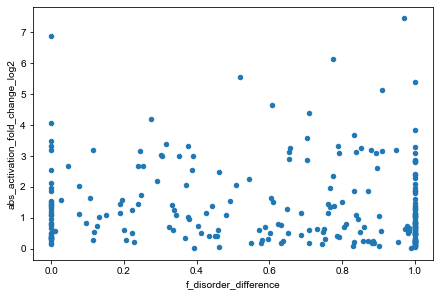

In [30]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [31]:
x_var = 'f_disorder_difference'
y_var = 'activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.06370616255636691, pvalue=0.3118590518479071)
SignificanceResult(statistic=0.10400813274601613, pvalue=0.09814186442840642)


In [32]:
x_var = 'f_disorder_difference'
y_var = 'abs_activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=-0.0833606689613687, pvalue=0.18540225759972911)
SignificanceResult(statistic=-0.1580083238252994, pvalue=0.011679653586540979)


<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='activation_fold_change_log2'>

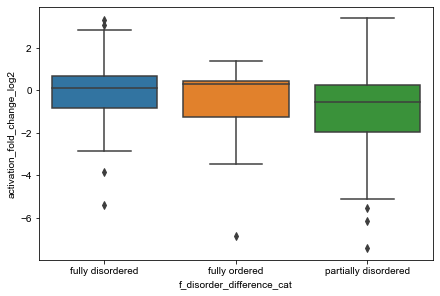

In [33]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

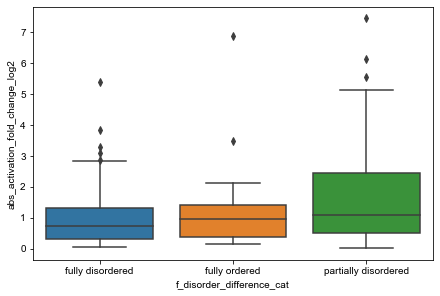

In [34]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='abs_activation_fold_change_log2')

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='abs_activation_fold_change_log2'>

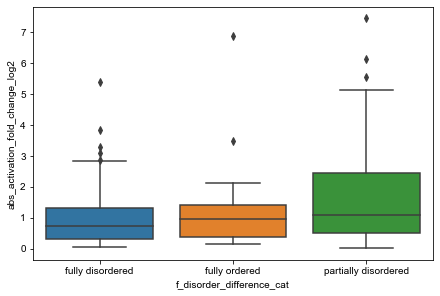

In [35]:
sns.boxplot(data=df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True), :],
            x='f_disorder_difference_cat',
            y='abs_activation_fold_change_log2')

In [36]:
stats.mannwhitneyu(
        df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully ordered'),
               'abs_activation_fold_change_log2'].values,
               df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully disordered')
               , 'abs_activation_fold_change_log2'].values
                          )

MannwhitneyuResult(statistic=842.0, pvalue=0.41349616924081445)

Interestingly, I don't see a difference between disordered and ordered changes and 
activation levels. Check for confounding factors like the size of the changes.

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='aa_seq_pct_identity'>

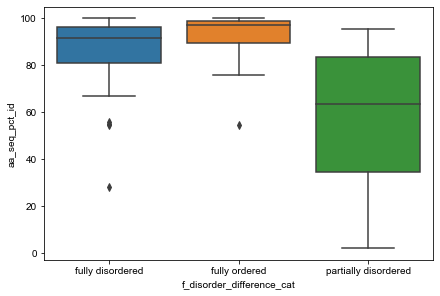

In [37]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='aa_seq_pct_identity', 
            order=['fully disordered',
                   'fully ordered',
                   'partially disordered'])

<AxesSubplot: xlabel='f_disorder_difference', ylabel='abs_activation_fold_change_log2'>

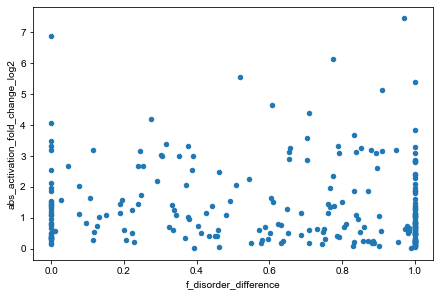

In [38]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [39]:
# x axis as size of change (or aa %id), y axis as act diff, split by dis and ordered

In [40]:
# check examples
(df.loc[df['f_disorder_difference_cat'] == 'fully ordered',
         :]
         .sort_values('abs_activation_fold_change_log2',
                      ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,ref_iso,alt_iso,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,length_of_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,length_of_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains,length_of_Bif_domains,fraction_of_AD_domains_removed_incl_pfam,insertion_in_AD_domains_incl_pfam,length_of_AD_domains_incl_pfam,fraction_of_RD_domains_removed_incl_pfam,insertion_in_RD_domains_incl_pfam,length_of_RD_domains_incl_pfam,fraction_of_Bif_domains_removed_incl_pfam,insertion_in_Bif_domains_incl_pfam,length_of_Bif_domains_incl_pfam,color_disorder,tot_dom_length,color_dom_length,tot_dom_length_incl_pfam,color_dom_length_incl_pfam
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,True,186,163,6,5,False,True,False,True,False,False,False,False,2.0,12.121212,True,86.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7.110312,0.246030,-6.864281,TBPL1-1,TBPL1-2,0.0,fully ordered,True,6.864281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.92907237, 0.68878959, 0.50411509, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",0.0,"(0.9155979, 0.55210684, 0.42070204)"
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,True,867,842,12,12,False,False,False,False,True,False,False,False,1.0,16.774194,True,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.318486,-0.146185,-3.464671,E2F8-1,E2F8-2,0.0,fully ordered,True,3.464671,NaN,NaN,NaN,0.0,0.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,80.0,NaN,NaN,NaN,"(0.92907237, 0.68878959, 0.50411509, 1.0)",80.0,"(0.89912041, 0.4510366, 0.37289175, 1.0)",80.0,"(0.89912041, 0.4510366, 0.37289175, 1.0)"
332,MLX,ENSG00000108788,bHLH,True,MLX|1/4|11G02,MLX|2/4|01D12,ENST00000435881,NaN,False,True,True,244,240,8,8,False,True,False,True,False,False,False,False,0.0,0.000000,False,88.8,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.774919,-0.354498,-2.129417,MLX-1,MLX-2,0.0,fully ordered,True,2.129417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.92907237, 0.68878959, 0.50411509, 1.0)",0.0,"(0.9155979, 0.55210684, 0.42070204)",0.0,"(0.9155979, 0.55210684, 0.42070204)"
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,True,509,501,11,11,True,False,False,False,False,False,False,False,0.0,0.000000,False,98.2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.185884,2.340298,-1.845586,NFIA-2,NFIA-3,0.0,fully ordered,True,1.845586,0.000000,0.0,83.0,0.0,0.0,280.0,NaN,NaN,NaN,0.000000,0.0,83.0,0.0,0.0,280.0,NaN,

In [41]:
df['f_disorder_difference_cat'].value_counts()

partially disordered    138
fully disordered         79
fully ordered            19
Name: f_disorder_difference_cat, dtype: int64

<AxesSubplot: xlabel='f_disorder_difference_cat', ylabel='PPI_jaccard'>

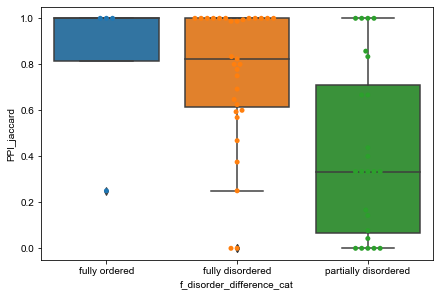

In [42]:
# TODO move PPI stuff to different notebook
sns.swarmplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')
sns.boxplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')

In [43]:
x = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully ordered'),
       'PPI_jaccard'].values
y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully disordered'),
       'PPI_jaccard'].values
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=79.0, pvalue=0.37652470660703774)

<AxesSubplot: xlabel='f_disorder_difference', ylabel='PPI_jaccard'>

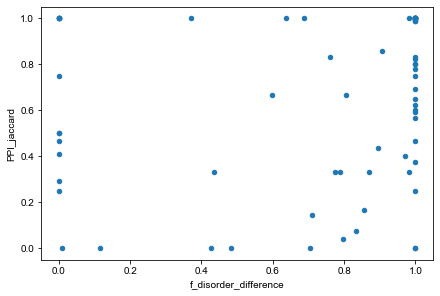

In [44]:
(df.loc[(df['n_positive_PPI_ref'] > 0) & 
        (df['n_positive_PPI_alt'] > 0), 
        :].plot.scatter(x='f_disorder_difference', y='PPI_jaccard'))

In [45]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.16152268143115292, pvalue=0.19160946964735043)
SignificanceResult(statistic=0.22757264006150346, pvalue=0.06401289943022384)


In [46]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              (df['f_disorder_difference'] > 0) &
              (df['f_disorder_difference'] < 1) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

PearsonRResult(statistic=0.2825089068106956, pvalue=0.181040038725035)
SignificanceResult(statistic=0.3134951916946277, pvalue=0.13577250432041632)
